In [24]:
import csv
import pandas as pd
import xml.etree.ElementTree as et
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from datetime import datetime as dt

### Leer fichero F24 con datos de un partido reemplazar el nombre aquí

In [25]:
tree = et.ElementTree(file = "f24-23-2020-2136563-eventdetails.xml")
games = tree.getroot()

In [26]:
match_details = games[0].attrib
match_details

{'id': '2136563',
 'additional_info': 'Behind Closed Doors',
 'away_score': '1',
 'away_team_id': '450',
 'away_team_name': 'Osasuna',
 'competition_id': '23',
 'competition_name': 'Spanish La Liga',
 'game_date': '2021-05-16T17:30:00',
 'home_score': '2',
 'home_team_id': '175',
 'home_team_name': 'Atlético de Madrid',
 'matchday': '37',
 'period_1_start': '2021-05-16T17:30:08',
 'period_2_start': '2021-05-16T18:35:55',
 'season_id': '2020',
 'season_name': 'Season 2020/2021'}

## Squads file

In [27]:
tree3 = et.ElementTree(file = "srml-23-2020-squads.xml")
soccerfeed = tree3.getroot()

In [28]:
player_ids = []
player_names = []

for child in soccerfeed:
    for grchild in child:
        if grchild.tag == "Team":
            for grgrchild in grchild:
                if grgrchild.tag == "Player":
                    player_ids.append(grgrchild.attrib["uID"].lstrip('p'))                     
                    for kchild in grgrchild:
                            if kchild.tag == "Name":
                                player_names.append(kchild.text)
                        
player_dict = dict(zip(player_ids, player_names))

#### Ver los primeros 10 elementos del dicccionario de jugadores

In [29]:
list(player_dict.items())[:10]

[('91406', 'Fernando Pacheco'),
 ('176245', 'Antonio Sivera'),
 ('220060', 'Aritz Castro'),
 ('244337', 'Tachi'),
 ('126119', 'Rubén Duarte'),
 ('93421', 'Rodrigo Ely'),
 ('49370', 'Víctor Laguardia'),
 ('246162', 'Martín Aguirregabiria'),
 ('77359', 'Florian Lejeune'),
 ('90728', 'Ximo Navarro')]

## Match preview summary

In [30]:
print ("%s v %s, %s %s" % (match_details["home_team_name"],
                          match_details["away_team_name"],
                          match_details["competition_name"][8:],
                          match_details["season_name"][7:]))


print ("Date: %s" % dt.strftime(dt.strptime(match_details["game_date"], '%Y-%m-%dT%H:%M:%S'),
                               "%A %d %B %Y"))

print ("Kick-off: %s" % dt.strftime(dt.strptime(match_details["game_date"], '%Y-%m-%dT%H:%M:%S'),
                               "%I%p").lstrip("0"))

Atlético de Madrid v Osasuna, La Liga 2020/2021
Date: Sunday 16 May 2021
Kick-off: 5PM


### Equipos diccionario

In [31]:
team_dict = {match_details["home_team_id"]: match_details["home_team_name"],
             match_details["away_team_id"]: match_details["away_team_name"]}

print (team_dict)

{'175': 'Atlético de Madrid', '450': 'Osasuna'}


## Passes

In [32]:
# PASSES

passes_x = []
passes_y = []
passes_outcome = []
passes_min = []
passes_sec = []
passes_period = []
passes_team = []
passes_x_end = []
passes_y_end = []
passes_length = []
passes_angle = []
passes_zone = []
pass_real = []
pass_player = []

for game in games:
    for event in game:
        
        if event.attrib.get("type_id") == '1':
            
            passes_x.append(event.attrib.get("x"))
            passes_y.append(event.attrib.get("y"))
            passes_outcome.append(event.attrib.get("outcome"))
            passes_min.append(event.attrib.get("min"))
            passes_sec.append(event.attrib.get("sec"))
            passes_period.append(event.attrib.get("period_id"))
            passes_team.append(team_dict[event.attrib.get("team_id")])
            pass_player.append(player_dict[event.attrib.get("player_id")])
            
            for q in event:
                
                qualifier = q.attrib.get("qualifier_id")
                
                if qualifier == "140":
                    passes_x_end.append(q.attrib.get("value"))
                if qualifier == "141":
                    passes_y_end.append(q.attrib.get("value"))
                if qualifier == "212":
                    passes_length.append(q.attrib.get("value"))
                if qualifier == "213":
                    passes_angle.append(q.attrib.get("value"))
                if qualifier == "56":
                    passes_zone.append(q.attrib.get("value"))
                    
                             
passes_df = np.array(list(zip(passes_team, pass_player, passes_period, passes_min, passes_sec, passes_zone, passes_x, 
                        passes_y, passes_x_end, passes_y_end, passes_length, passes_angle,passes_outcome)))

print (passes_df)

fieldnames = ["team", "player", "period", "min", "sec", "pass zone", "x", "y", "x_end", "y_end",
              "pass length", "pass angle", "outcome"]

with open("pass_data_%s_%s.csv" % (match_details["home_team_name"], match_details["away_team_name"]),"w",newline='') as passes_csv:
        csv_file = csv.writer(passes_csv)
        csv_file.writerow(fieldnames)
        for i in range(len(passes_df)):
            csv_file.writerow(passes_df[i])

[['Osasuna' 'Darko Brasanac' '1' ... '13.3' '3.2' '1']
 ['Osasuna' 'Jon Moncayola' '1' ... '28.4' '1.6' '1']
 ['Osasuna' 'Rubén García' '1' ... '35.4' '5.7' '1']
 ...
 ['Osasuna' 'Enric Gallego' '2' ... '14.2' '1.7' '1']
 ['Atlético de Madrid' 'Jan Oblak' '2' ... '70.2' '5.9' '0']
 ['Osasuna' 'Lucas Torró' '2' ... '14.0' '6.0' '0']]


In [33]:
passes_df

array([['Osasuna', 'Darko Brasanac', '1', ..., '13.3', '3.2', '1'],
       ['Osasuna', 'Jon Moncayola', '1', ..., '28.4', '1.6', '1'],
       ['Osasuna', 'Rubén García', '1', ..., '35.4', '5.7', '1'],
       ...,
       ['Osasuna', 'Enric Gallego', '2', ..., '14.2', '1.7', '1'],
       ['Atlético de Madrid', 'Jan Oblak', '2', ..., '70.2', '5.9', '0'],
       ['Osasuna', 'Lucas Torró', '2', ..., '14.0', '6.0', '0']],
      dtype='<U18')

In [34]:
passes = pd.DataFrame(passes_df,columns=["team", "player", "period", "min", "sec", "pass zone", "x", "y", "x_end", "y_end",
              "pass length", "pass angle", "outcome"])

In [35]:
passes['period'] = passes['period'].astype('int64')
passes['min'] = passes['min'].astype('int64')
passes['sec'] = passes['sec'].astype('int64')
passes['x'] = passes['x'].astype('float64')
passes['y'] = passes['y'].astype('float64')
passes['x_end'] = passes['x_end'].astype('float64')
passes['y_end'] = passes['y_end'].astype('float64')
passes['pass length'] = passes['pass length'].astype('float64')
passes['pass angle'] = passes['pass angle'].astype('float64')
passes['outcome'] = passes['outcome'].astype('int64')

In [36]:
passes.dtypes

team            object
player          object
period           int64
min              int64
sec              int64
pass zone       object
x              float64
y              float64
x_end          float64
y_end          float64
pass length    float64
pass angle     float64
outcome          int64
dtype: object

In [37]:
passes.head(15)

,team,player,period,min,sec,pass zone,x,y,x_end,y_end,pass length,pass angle,outcome
0,Osasuna,Darko Brasanac,1,0,0,Back,49.9,50.5,37.2,50.3,13.3,3.2,1
1,Osasuna,Jon Moncayola,1,0,0,Back,37.4,50.3,36.0,92.0,28.4,1.6,1
2,Osasuna,Rubén García,1,0,5,Center,36.4,92.0,65.0,64.3,35.4,5.7,1
3,Osasuna,Ante Budimir,1,0,7,Center,65.0,64.3,58.6,70.0,7.8,2.6,1
4,Osasuna,Darko Brasanac,1,0,8,Center,58.6,70.0,94.5,75.7,37.9,0.1,0
5,Atlético de Madrid,Jan Oblak,1,0,16,Back,8.8,32.5,19.3,93.6,43.0,1.3,1
6,Atlético de Madrid,Mario Hermoso,1,0,20,Back,22.9,94.2,28.9,78.2,12.6,5.2,1
7,Atlético de Madrid,Koke,1,0,22,Back,29.4,78.0,39.2,95.7,15.8,0.9,1
8,Atlético de Madrid,Mario Hermoso,1,0,26,Back,42.9,95.7,36.9,86.6,8.8,3.9,1
9,Atlético de Madrid,Koke,1,0,30,Back,41.7,74.9,34.0,51.0,18.2,4.3,1


Filtramos los pases de un jugador

In [38]:
pasesJugador= passes.loc[passes['player'] == "Yannick Carrasco"]

pasesJugador= pasesJugador.reset_index()

pasesJugador.head()

,index,team,player,period,min,sec,pass zone,x,y,x_end,y_end,pass length,pass angle,outcome
0,14,Atlético de Madrid,Yannick Carrasco,1,0,51,Back,45.5,97.4,33.6,87.6,14.2,3.6,1
1,23,Atlético de Madrid,Yannick Carrasco,1,1,35,Center,45.9,73.5,54.5,71.0,9.2,6.1,1
2,32,Atlético de Madrid,Yannick Carrasco,1,1,57,Center,62.0,55.2,71.6,57.5,10.2,0.2,1
3,36,Atlético de Madrid,Yannick Carrasco,1,2,13,Center,94.6,74.6,86.2,54.4,16.3,4.1,0
4,47,Atlético de Madrid,Yannick Carrasco,1,3,11,Left,52.7,77.7,50.9,96.5,12.9,1.7,1


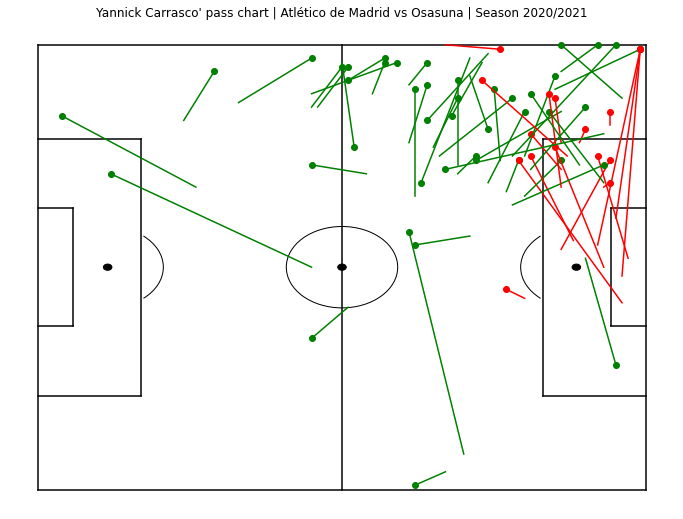

In [61]:
fig=plt.figure()
fig.set_size_inches(12, 9) # Cambiar aqui el tamaño (Ancho, Alto)
ax=fig.add_subplot(1,1,1)

titulo = "Yannick Carrasco' pass chart"
plt.title(titulo + " | " + match_details["home_team_name"] + ' vs ' + match_details["away_team_name"] +' | '+ match_details["season_name"])

# Pitch Outline & Centre Line OK
plt.plot([0,0],[0,100], color="black")
plt.plot([0,100],[100,100], color="black") #upper line x_start x_end y_start y_end
plt.plot([100,100],[100,0], color="black")
plt.plot([100,0],[0,0], color="black")
plt.plot([50,50],[0,100], color="black")

# Left Penalty Area OK
plt.plot([17,17],[78.9,21.1],color="black")
plt.plot([0,17],[78.9,78.9],color="black")
plt.plot([17,0],[21.1,21.1],color="black")

# Right Penalty Area OK
plt.plot([100,83],[78.9,78.9],color="black")
plt.plot([83,83],[78.9,21.1],color="black")
plt.plot([83,100],[21.1,21.1],color="black")

# Left 6-yard Box on testing
plt.plot([0,5.8],[63.2,63.2],color="black")
plt.plot([5.8,5.8],[63.2,36.8],color="black")
plt.plot([5.8,0],[36.8,36.8],color="black")

# Right 6-yard Box on testing
plt.plot([100,94.2],[63.2,63.2],color="black")
plt.plot([94.2,94.2],[63.2,36.8],color="black")
plt.plot([94.2,100],[36.8,36.8],color="black")

# Prepare Circles OK
centreCircle = plt.Circle((50,50),9.15,color="black",fill=False)
centreSpot = plt.Circle((50,50),0.7,color="black")
leftPenSpot = plt.Circle((11.5,50),0.7,color="black")
rightPenSpot = plt.Circle((88.5,50),0.7,color="black")

# Draw Circles
ax.add_patch(centreCircle)
ax.add_patch(centreSpot)
ax.add_patch(leftPenSpot)
ax.add_patch(rightPenSpot)

# Prepare Arcs based on penalty Spots 
leftArc = Arc((11.5,50),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="black")
rightArc = Arc((88.5,50),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="black")

# leftArc = Arc((17,50),height=18.3,width=18.3,angle=0,theta1=310,theta2=50,color="blue")
# rightArc = Arc((83,50),height=18.3,width=18.3,angle=0,theta1=130,theta2=230,color="red")

# Draw Arcs
ax.add_patch(leftArc)
ax.add_patch(rightArc)

# Tidy Axes
plt.axis('off')

####################
# PLOT PASSES
####################

for i in range(len(pasesJugador)):
    color = "green" if pasesJugador.iloc[i]['outcome'] == 1 else "red"
    plt.plot([int(pasesJugador["x"][i]),int(pasesJugador["x_end"][i])],
             [int(pasesJugador["y"][i]),int(pasesJugador["y_end"][i])], color=color)
    plt.plot(int(pasesJugador["x"][i]),int(pasesJugador["y"][i]),"o", color=color)

plt.savefig(titulo)
plt.show()


In [65]:
#EXTRA: Obteniendo numero de pases por cada zona del campo
zonas = list(pasesJugador['pass zone'].unique())

npasesXzone = []
for zona in zonas:
    pxz = len(pasesJugador.loc[pasesJugador['pass zone'] == zona])
    npasesXzone.append(pxz)

zone_npass = dict(zip(zonas,npasesXzone))

print('PASES SEGÚN LA ZONA DONDE SE REALIZARON:')
print(zone_npass)

PASES SEGÚN LA ZONA DONDE SE REALIZARON:
{'Back': 7, 'Center': 34, 'Left': 17, 'Right': 2}


In [58]:
type(titulo)

str